## 1. Classical Segmentation Implementation

In [13]:
import time

from utils import *
from models import ClassicalSegmentation

print(f"Using device: {device}")

Using device: cuda


Loaded 10 images for train split


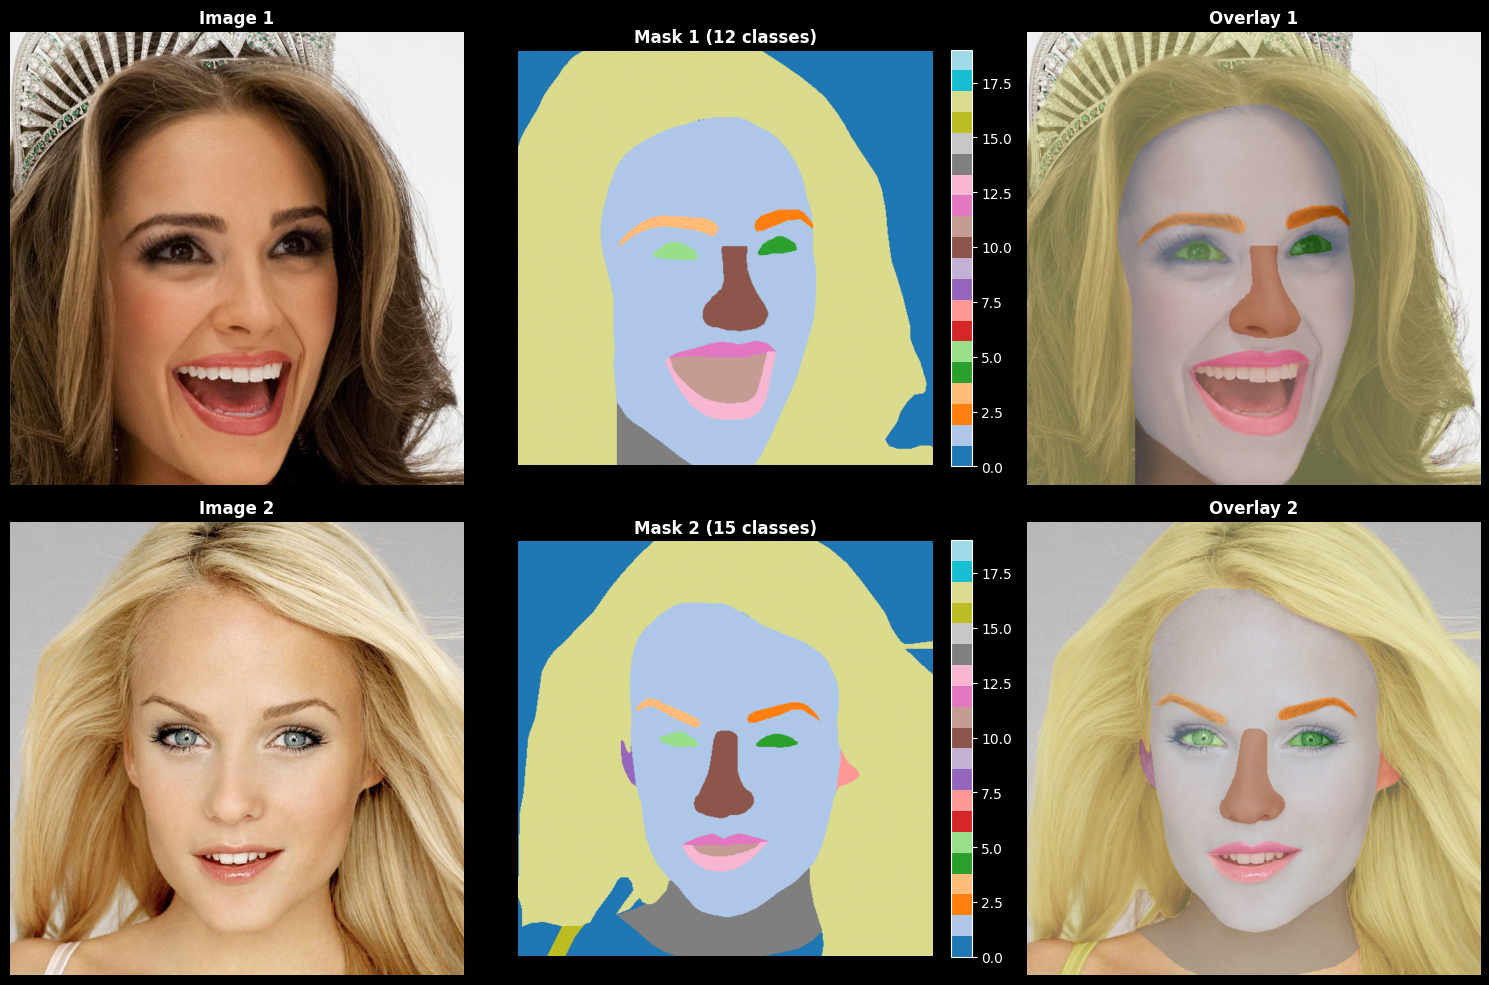

In [14]:
train_images, train_masks = load_celebamask_data(split='train', max_samples=10)
visualize_samples(train_images, train_masks, num_samples=2)

Training GMM on 5 images...
✓ Training complete

Testing on 5 images...
✓ Average inference time: 1.0313s
✓ Saved to: ../../Report/results/classical_segmentation_results.png


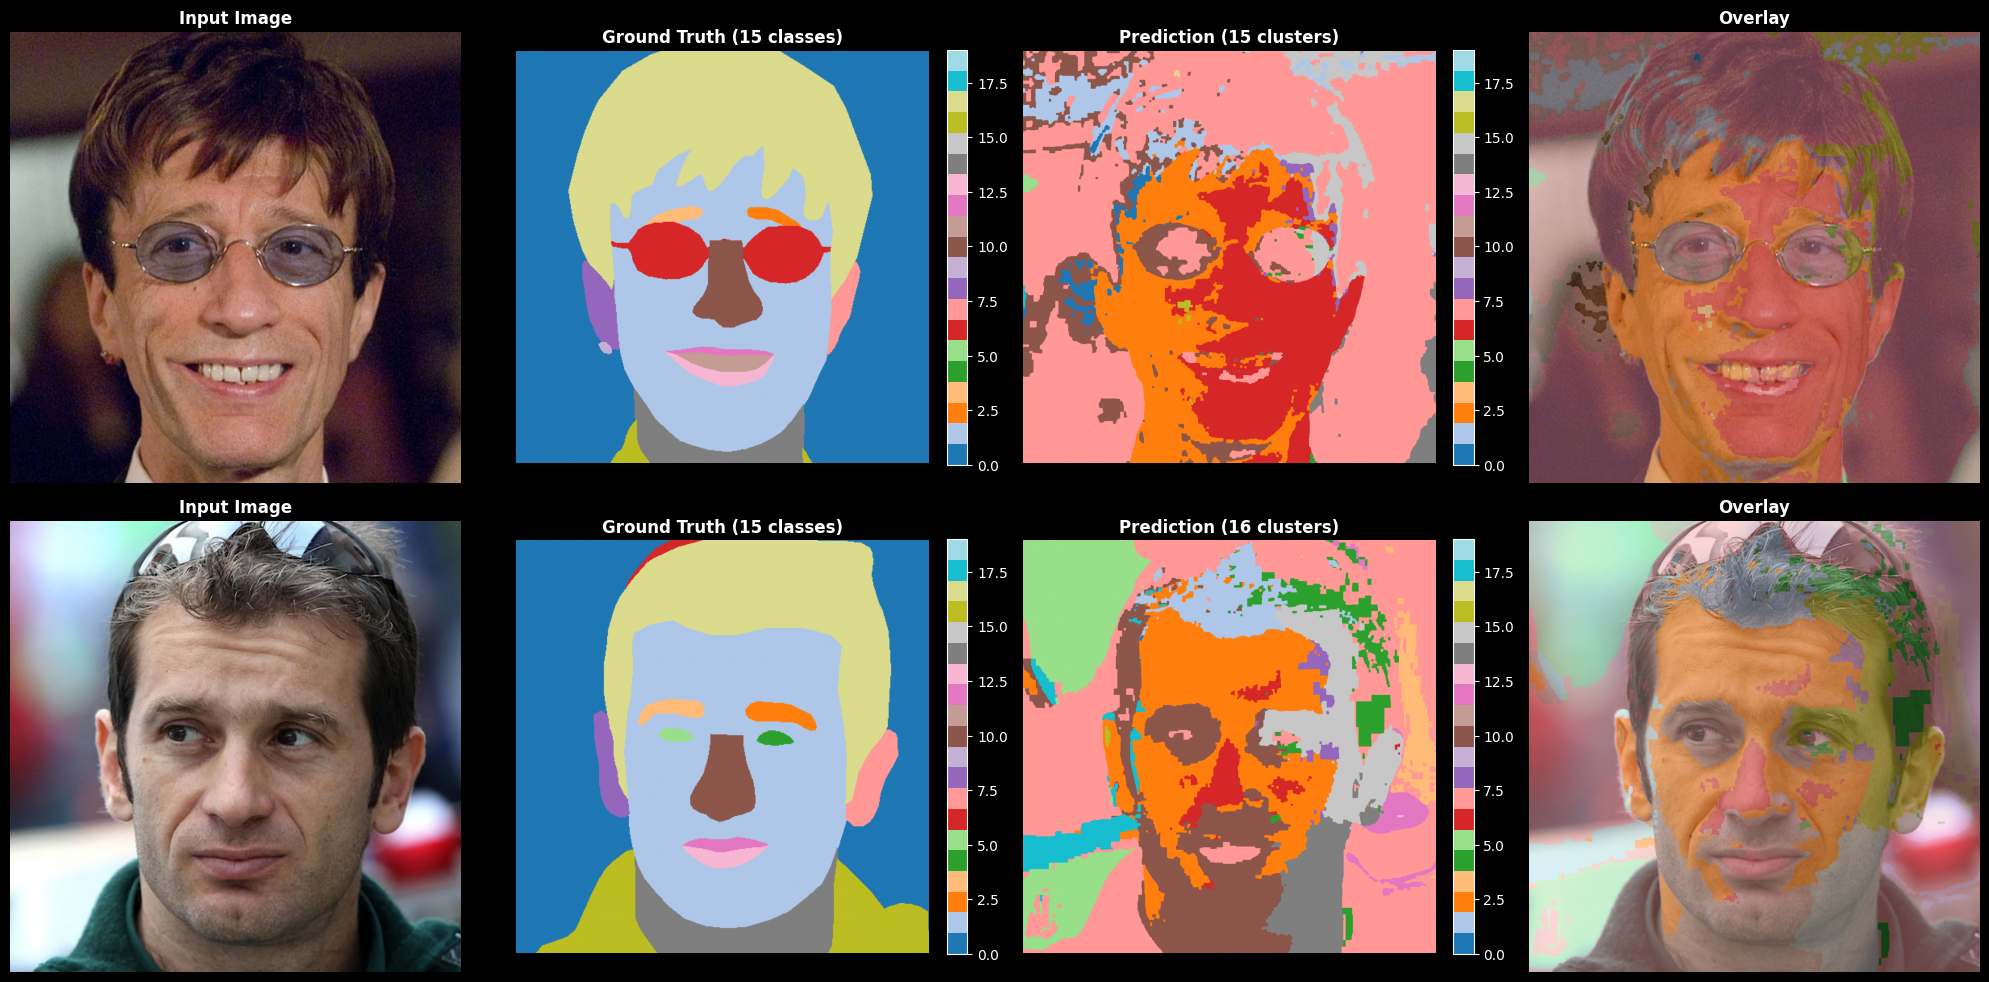

In [15]:
train_imgs = train_images[:5]
train_masks_subset = train_masks[:5]
test_imgs = train_images[5:10]
test_masks_gt = train_masks[5:10]

print("Training GMM on 5 images...")
classical_model = ClassicalSegmentation(n_components=19)
classical_model.fit(train_imgs, train_masks_subset)
print("✓ Training complete")

print(f"\nTesting on {len(test_imgs)} images...")
classical_predictions = []
inference_times = []

for i, test_img in enumerate(test_imgs):
    start_time = time.time()
    pred_mask = classical_model.predict(test_img)
    inference_times.append(time.time() - start_time)
    classical_predictions.append(pred_mask)

avg_inference_time = np.mean(inference_times)
print(f"✓ Average inference time: {avg_inference_time:.4f}s")

visualize_predictions(
    images=test_imgs,
    true_masks=test_masks_gt,
    predictions=classical_predictions,
    num_samples=2,
    save_path=RESULTS_DIR / 'classical_segmentation_results.png'
)

classical_results = {
    'predictions': classical_predictions,
    'inference_time': avg_inference_time,
    'test_images': test_imgs,
    'test_masks': test_masks_gt
}

In [16]:
all_metrics = []
for pred, gt in zip(classical_results['predictions'], classical_results['test_masks']):
    metrics = calculate_clustering_metrics(pred, gt)
    all_metrics.append(metrics)

avg_ari = np.mean([m['ARI'] for m in all_metrics])
avg_nmi = np.mean([m['NMI'] for m in all_metrics])
avg_iou = np.mean([m['Best_IoU'] for m in all_metrics])

print("="*70)
print("CLASSICAL SEGMENTATION METRICS")
print("="*70)
print(f"Adjusted Rand Index (ARI):     {avg_ari:.4f}")
print(f"Normalized Mutual Info (NMI):  {avg_nmi:.4f}")
print(f"Best-case mean IoU:            {avg_iou:.4f}")
print(f"Average Inference Time:        {classical_results['inference_time']:.4f}s")
print("="*70)

import pandas as pd
metrics_df = pd.DataFrame([{
    'Method': 'Classical (GMM)',
    'ARI': avg_ari,
    'NMI': avg_nmi,
    'Best_IoU': avg_iou,
    'Inference_Time_s': classical_results['inference_time']
}])
metrics_df.to_csv(RESULTS_DIR / 'classical_metrics.csv', index=False)
print(f"✓ Metrics saved to {RESULTS_DIR /  'classical_metrics.csv'}")

CLASSICAL SEGMENTATION METRICS
Adjusted Rand Index (ARI):     0.2820
Normalized Mutual Info (NMI):  0.3883
Best-case mean IoU:            0.1358
Average Inference Time:        1.0313s
✓ Metrics saved to ../../Report/results/classical_metrics.csv


### Analysis

The classical GMM-based segmentation shows poor performance (ARI ≈ 0.28, NMI ≈ 0.39, Best IoU ≈ 0.14), as evidenced both visually and quantitatively. The method suffers from fundamental limitations: it performs unsupervised clustering based on color similarity rather than semantic understanding, cannot distinguish between regions with similar colors (e.g., face, neck, ears all have similar skin tones), and lacks spatial context or shape priors. These arbitrary clusters do not correspond to meaningful facial parts, demonstrating why supervised deep learning methods are necessary for accurate semantic segmentation. Despite fast inference (0.8s), the low accuracy makes this approach unsuitable for production use, serving primarily as a baseline for comparison with modern methods (YOLO-Seg, BiSeNet, SAM3).